<a href="https://colab.research.google.com/github/yupopov/stepik-dl-cv/blob/main/module03_sin_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One-dimensional regression with fully connected networks

In this notebook we will approximate the noisy sine data with a simple fully connected neural network (1 hidden layer with sigmoid activation) and see how various network parameters (such as the learning rate, the activation function, number of epochs...) affect the quality of our network.

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (13.0, 5.0)

# Train dataset

Let's sample a sine function and add noise to the data:

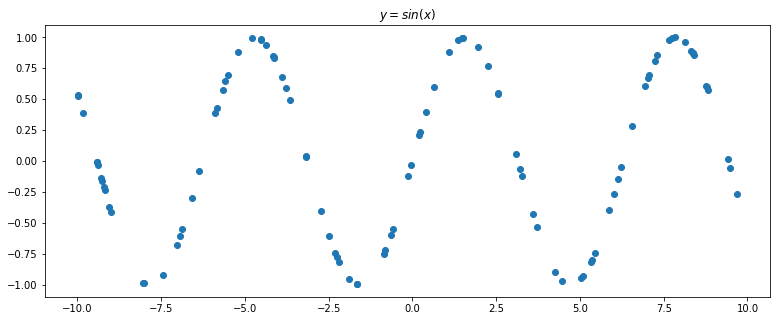

In [3]:
x_train = torch.rand(100)
x_train = x_train * 20.0 - 10.0

y_train = torch.sin(x_train)

plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title('$y = sin(x)$');

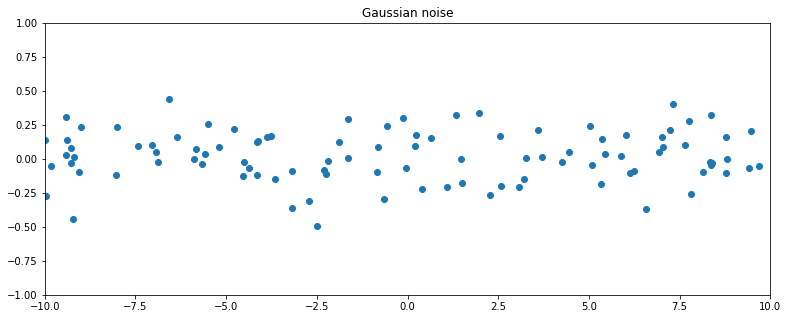

In [4]:
noise = torch.randn(y_train.shape) / 5.

plt.plot(x_train.numpy(), noise.numpy(), 'o')
plt.axis([-10, 10, -1, 1])
plt.title('Gaussian noise');

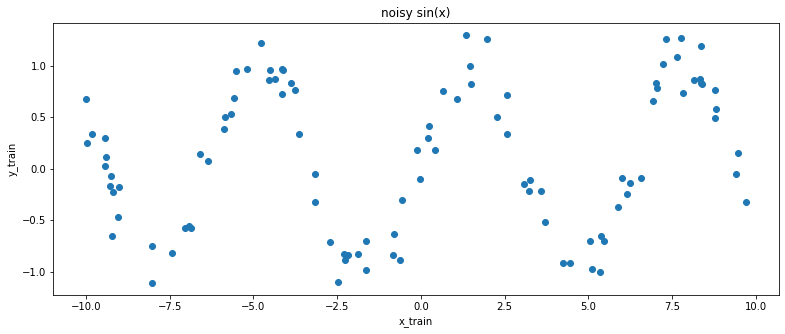

In [5]:
y_train = y_train + noise
plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title('noisy sin(x)')
plt.xlabel('x_train')
plt.ylabel('y_train');

Change the dimensions of the vectors so that they are PyTorch-compliant:

In [6]:
x_train.unsqueeze_(1)
y_train.unsqueeze_(1);

In [7]:
tmp = torch.Tensor([1,2,3])
print(tmp)
print(tmp.unsqueeze(1))

tensor([1., 2., 3.])
tensor([[1.],
        [2.],
        [3.]])


# Validation dataset

For the validation we will use noiseless sine data.

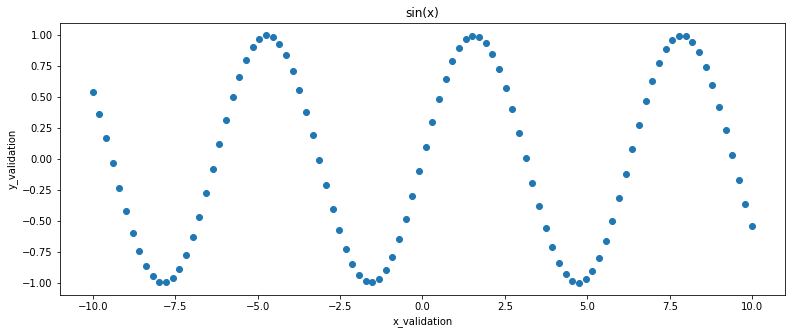

In [8]:
x_validation = torch.linspace(-10, 10, 100)
y_validation = torch.sin(x_validation.data)
plt.plot(x_validation.numpy(), y_validation.numpy(), 'o')
plt.title('sin(x)')
plt.xlabel('x_validation')
plt.ylabel('y_validation');

In [9]:
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1);

# Model construction

Our network will have just 1 hidden layer:

In [10]:
class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(SineNet, self).__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

sine_net = SineNet(10)

# Prediction

Our network's weights are initialied with random numbers, so we shouldn't expect it to predict anything until we train it:

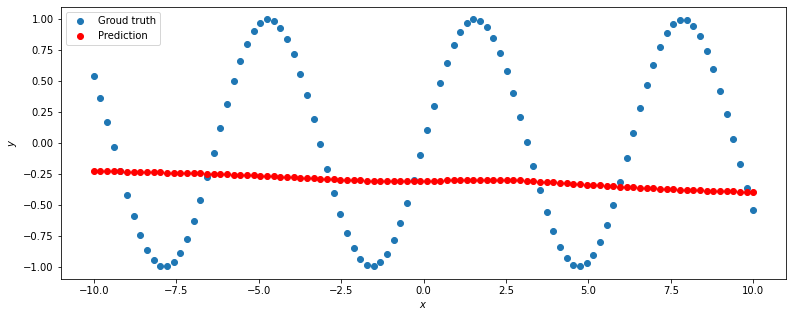

In [11]:
def predict(net, x, y):
    y_pred = net.forward(x)

    plt.plot(x.numpy(), y.numpy(), 'o', label='Groud truth')
    plt.plot(x.numpy(), y_pred.data.numpy(), 'o', c='r', label='Prediction');
    plt.legend(loc='upper left')
    plt.xlabel('$x$')
    plt.ylabel('$y$')

predict(sine_net, x_validation, y_validation)

# Optimizer

We choose Adam as the optimizer, although we will experiment with its choice later.

In [ ]:
optimizer = torch.optim.Adam(sine_net.parameters(), lr=0.01)

# Loss function

Our loss function is the MSE, nothing original here.

In [ ]:
def loss(pred, target):
    squares = (pred - target) ** 2
    return squares.mean()

# Training procedure

Now, let's train our network and see if it can approximate the target function.

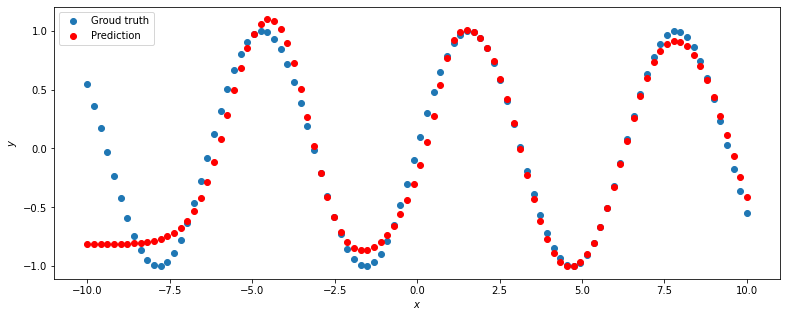

In [ ]:
for epoch_index in range(2000):
    optimizer.zero_grad()

    y_pred = sine_net.forward(x_train)
    loss_val = loss(y_pred, y_train)

    loss_val.backward()

    optimizer.step()

predict(sine_net, x_validation, y_validation)

# Task: approximation of the function $f(x) = 2^x\sin(2^{-x})$

*Try to approximate the function $2^x\sin(2^{-x})$. Modify the network structure and achieve the $L_1$ loss of 0.02.*

In [ ]:
def target_function(x):
    return 2**x * torch.sin(2**-x)

Let's generate and plot the train data:

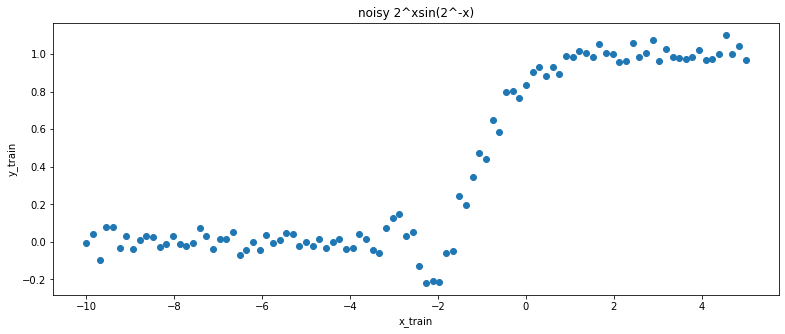

In [ ]:
x_train =  torch.linspace(-10, 5, 100)
y_train = target_function(x_train)
noise = torch.randn(y_train.shape) / 20.
y_train = y_train + noise
plt.plot(x_train.numpy(), y_train.numpy(), 'o')
plt.title('noisy 2^xsin(2^-x)')
plt.xlabel('x_train')
plt.ylabel('y_train');

In [ ]:
x_train.unsqueeze_(1)
y_train.unsqueeze_(1)

x_validation = torch.linspace(-10, 5, 100)
y_validation = target_function(x_validation)
x_validation.unsqueeze_(1)
y_validation.unsqueeze_(1)

Now let's try to approximate the target function.

We tuned the architecture of the network (the number of hidden layers and the activation functions) and the optimization parameters (the optimizator itself, the learning rate and the number of epochs). We found that:
- Two hidden layers work better than one, but three hidden layers give no significant increase;
- Sigmoid activation functions work better than ReLU and Tanh;
- We achieve the best quality with `n_hidden_neurons` around 20, after that, the network starts overfitiing;
- Adam optimizer works significantly better than SGD;
- After 10000 epochs the network begins to overfit; 

In [ ]:
def make_regression_net(n_hidden_neurons):
   return torch.nn.Sequential(
       torch.nn.Linear(1, n_hidden_neurons),
       torch.nn.Sigmoid(),
       torch.nn.Linear(n_hidden_neurons, n_hidden_neurons),
       torch.nn.Sigmoid(),
       torch.nn.Linear(n_hidden_neurons, 1)
       )

net = make_regression_net(n_hidden_neurons=20)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

In [ ]:
def loss(pred, target):
    return ((pred - target)**2).mean()

def metric(pred, target):
    return (pred - target).abs().mean()

L1 norm of the difference of predicted data and y_validation: 0.0174


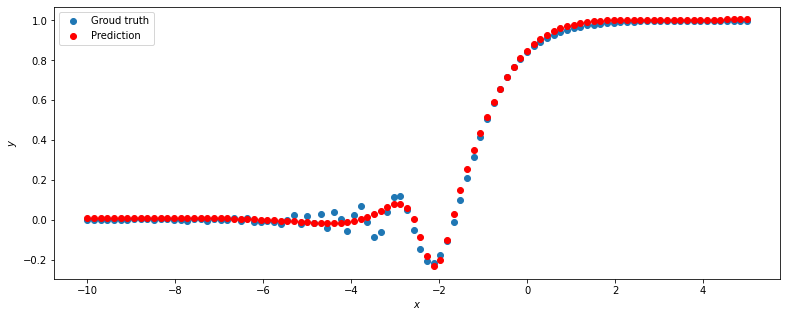

In [ ]:
for epoch_index in range(10000):
  optimizer.zero_grad()

  y_pred = net.forward(x_train)
  loss_value = loss(y_train, y_pred)
  loss_value.backward()
  optimizer.step()

predict(net, x_validation, y_validation)
print(f'L1 norm of the difference of predicted data and y_validation: {metric(net.forward(x_validation), y_validation).item():.4f}')